<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-04-glm-ordinal-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 4. Ordinal or Ordered Logistic Regression (OLR)

Ordered logistic regression is used when the dependent variable is an ordinal outcome—a categorical variable with a precise rank order but not necessarily equidistant. This method estimates each response level's probability while considering the outcome's ordered nature. Typical applications include customer satisfaction assessment, academic grading, and income classification. In this tutorial, we will discuss ordered logistic regression, manually fit a model to understand its mechanics, and use the `polr()` function from the {MASS} package in R to implement the model. We will also examine coefficients, odds ratios, and category thresholds. This tutorial will provide a practical approach to mastering ordinal logistic regression through concepts and hands-on coding.


## Overview

**Ordinal logistic regression (OLR)** is a statistical method used to analyze the relationship between one or more independent variables (predictors) and an ordinal dependent variable. An ordinal variable is a type of categorical variable where the categories have a specific order, but the intervals between the categories are not uniformly measured. This technique is commonly used in social sciences, psychology, and other fields where data is measured on Likert scales (e.g., strongly disagree, disagree, neutral, agree, strongly agree) or in scenarios where outcomes are ordered such as grades (e.g., A, B, C, D, F). OLR allows researchers to understand the impact of independent variables on the likelihood of an outcome falling into a particular category or higher.

In ordinal logistic regression (OLR), the dependent variable is assumed to have three or more ordered categories. The objective is to predict the probability of an observation falling into one of the categories based on the independent variables' values. OLR is an extension of logistic regression, which is used for binary outcomes, and it is designed to handle multiple ordered outcome categories.

The key difference between ordinal variables and nominal variables (which have no inherent order, like colors or types of fruit) is that ordinal variables convey a rank or order.

**Proportional Odds Assumption**: The primary assumption in ordinal logistic regression is that the relationship between each pair of outcome groups is the same across all levels of the independent variables. In other words, the odds ratios comparing any two outcome categories are constant across all levels of the predictor variables.

1.  **Model Specification**:

    -   Let $Y$ be an ordinal variable with $K$ categories. Define $P(Y \leq k)$ as the probability of being in category $k$ or lower.

    -   The model assumes that each category has a threshold $\theta_k$ such that:

  $$ \text{logit}(P(Y \leq k)) = \theta_k - X\beta $$

  for $k = 1, \ldots, K-1$

2.  **Link Function**:

    -   The cumulative logit link function is typically used, so:

$$  P(Y \leq k) = \frac{1}{1 + e^{-(\theta_k - X\beta)}} $$

3.  **Parameter Estimation**:

    -   Maximum likelihood estimation is used to estimate both $\beta$ and \$\theta\_k\$0.

    -   The log-likelihood is based on the cumulative probabilities:

        $$ \mathcal{L}(\beta, \theta) = \sum_{i=1}^n \sum_{k=1}^{K-1} I(Y_i \leq k) \ln(P(Y_i \leq k)) + I(Y_i > k) \ln(1 - P(Y_i \leq k)) $$

4.  **Prediction**:

    -   The model predicts the probability of $Y$ falling within each category by computing $P(Y \leq k)$ for each $k$.

5.  **Interpretation**:

    -   The coefficients $\beta$ represent the change in the log-odds of being in a higher vs. lower category for a one-unit increase in $X$.



## Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314975 sha256=c08fb0f4f1d168adc8ce81c420645a1b3b67082bf952fa8e40102310f11ccd52
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Building a Ordinal Model from Scratch

Fitting an ordinal logistic regression model from scratch in R without using any external packages involves several steps, including creating synthetic data, calculating the cumulative probabilities, estimating the model coefficients using Maximum Likelihood Estimation (MLE), and deriving the summary statistics and odds ratios with confidence intervals. Below, I will outline how to accomplish this step-by-step.


### Generate Synthetic Data

We'll create a synthetic dataset with 6 continuous predictors, one categorical predictor, and an ordinal response variable with three levels.


In [ ]:
%%R
# Load required package for numerical derivatives
if (!require(numDeriv)) install.packages("numDeriv")

# Step 1: Generate Synthetic Data
set.seed(123)  # For reproducibility
n <- 200  # Number of observations

# Continuous predictors
X1 <- rnorm(n)
X2 <- rnorm(n)
X3 <- rnorm(n)
X4 <- rnorm(n)


# Categorical predictor (two levels)
land_type <- sample(c("high land", "medium high land"), n, replace = TRUE)

# Convert land_type to a numeric binary variable
land_type_numeric <- ifelse(land_type == "high land", 1, 0)

# Create a linear predictor and generate response variable
linear_predictor <- 1 + 0.5 * X1 - 0.3 * X2 + 0.2 * X3 +
                    0.7 * land_type_numeric +
                    rnorm(n)

# Define thresholds for response categories
thresholds <- c(-Inf, 0, 1, Inf)  # Create three categories (Low, Moderate, High)
response <- cut(linear_predictor, breaks = thresholds, labels = c("Low", "Moderate", "High"))

# Combine data into a data frame
data <- data.frame(X1, X2, X3, X4,  land_type_numeric, response)
head(data)

### Define Model Functions

In [ ]:
%%R
# Step 2: Define Model Functions

# Function to compute cumulative probabilities
cumulative_probs <- function(X, beta, alpha) {
  eta <- cbind(1, X) %*% beta  # Linear predictor with intercept
  prob_low <- 1 / (1 + exp(-(eta - alpha[1])))
  prob_moderate <- prob_low / (1 + exp(-(eta - alpha[2])))
  prob_high <- 1 - prob_moderate
  return(cbind(prob_low, prob_moderate, prob_high))
}

# Function to compute the log-likelihood
log_likelihood <- function(params, data) {
  beta <- params[1:6]  # 8 coefficients for predictors + intercept
  alpha <- params[7:8]  # Two thresholds

  # Define predictor matrix X (5 predictors plus intercept)
  X <- as.matrix(data[, c("X1", "X2", "X3", "X4", "land_type_numeric")])

  response <- factor(data$response, levels = c("Low", "Moderate", "High"))

  # Calculate cumulative probabilities
  probs <- cumulative_probs(X, beta, alpha)

  # Compute log likelihood
  ll <- sum(log(ifelse(response == "Low", probs[, 1],
                ifelse(response == "Moderate", probs[, 2],
                       probs[, 3]))))
  return(-ll)  # Return negative log-likelihood for minimization
}

### Fit the Model

In [ ]:
%%R
# Step 3: Fit the Model

# Function to fit the model using optim
fit_model <- function(data) {
  init_params <- rep(0, 8)  # 8 for beta (including intercept) and 2 thresholds
  result <- optim(init_params, log_likelihood, data = data, method = "BFGS", hessian = TRUE)
  return(result)
}

# Fit the model
model_fit <- fit_model(data)
model_fit$par  # Model coefficients (beta) and thresholds (alpha)

[1]  4.314075699 -0.982913650  0.524043957  0.042348956 -0.009382339
[6] -1.523786205 -8.913837528  4.599729893


### Extract Coefficients and Compute Standard Errors

In [ ]:
%%R
# Step 4: Extract Coefficients and Compute Standard Errors

# Compute the Hessian matrix and standard errors
hessian_matrix <- model_fit$hessian
standard_errors <- sqrt(diag(solve(hessian_matrix)))
standard_errors

[1]       NaN 0.2382101 0.2000665 0.2103150 0.1922551 0.4043306       NaN
[8]       NaN


### Create a Summary Table

In [ ]:
%%R
# Step 5: Create a Summary Table

# Coefficients and standard errors
coefficients <- model_fit$par
t_values <- coefficients / standard_errors
p_values <- 2 * (1 - pnorm(abs(t_values)))  # Two-tailed p-values

# Summary table
summary_table <- data.frame(
  Value = coefficients,
  Std_Error = standard_errors,
  t_value = t_values,
  p_value = p_values
)

rownames(summary_table) <- c(paste("X", 1:4, sep = ""), "land_high", "Intercept", "alpha_1", "alpha_2")
summary_table

                 Value Std_Error    t_value      p_value
X1         4.314075699       NaN        NaN          NaN
X2        -0.982913650 0.2382101 -4.1262462 3.687325e-05
X3         0.524043957 0.2000665  2.6193491 8.809775e-03
X4         0.042348956 0.2103150  0.2013596 8.404174e-01
land_high -0.009382339 0.1922551 -0.0488015 9.610775e-01
Intercept -1.523786205 0.4043306 -3.7686644 1.641233e-04
alpha_1   -8.913837528       NaN        NaN          NaN
alpha_2    4.599729893       NaN        NaN          NaN


### Calculate Odds Ratios and Confidence Intervals


In [ ]:
%%R
# Step 6: Calculate Odds Ratios and Confidence Intervals

# Calculate odds ratios and CI
odds_ratios <- exp(coefficients)
ci_lower <- exp(coefficients - 1.96 * standard_errors)
ci_upper <- exp(coefficients + 1.96 * standard_errors)

# Create a table for odds ratios and CI
odds_ratios_table <- data.frame(
  Odds_Ratio = odds_ratios,
  CI_Lower = ci_lower,
  CI_Upper = ci_upper
)

rownames(odds_ratios_table) <- rownames(summary_table)
odds_ratios_table

            Odds_Ratio   CI_Lower  CI_Upper
X1        7.474451e+01        NaN       NaN
X2        3.742192e-01 0.23461591 0.5968904
X3        1.688843e+00 1.14100979 2.4997089
X4        1.043258e+00 0.69082517 1.5754901
land_high 9.906615e-01 0.67963296 1.4440298
Intercept 2.178854e-01 0.09864043 0.4812837
alpha_1   1.345146e-04        NaN       NaN
alpha_2   9.945745e+01        NaN       NaN


### Cross-validation

To evaluate the model's performance using cross-validation, we’ll use k-fold cross-validation, where we split the data into k folds, train on k-1 folds, and test on the remaining fold. We repeat this process k times, each time using a different fold as the test set, and then compute the average accuracy across all folds.

In [ ]:
%%R
# Load required package for sampling
if (!require(numDeriv)) install.packages("numDeriv")

# Function to calculate accuracy
calculate_accuracy <- function(true_labels, predicted_labels) {
  mean(true_labels == predicted_labels)
}

# Define the model fitting function
fit_model <- function(data) {
  init_params <- rep(0, 8)  # 8 for beta (including intercept) and 2 thresholds
  result <- optim(init_params, log_likelihood, data = data, method = "BFGS", hessian = TRUE)
  return(result)
}

# Define the prediction function
predict_ordinal <- function(test_data, params) {
  beta <- params[1:6]  # Coefficients for predictors + intercept
  alpha <- params[7:8]  # Thresholds

  # Define predictor matrix X for test data
  X <- as.matrix(test_data[, c("X1", "X2", "X3", "X4",  "land_type_numeric")])

  # Compute cumulative probabilities
  eta <- cbind(1, X) %*% beta  # Linear predictor with intercept
  prob_low <- 1 / (1 + exp(-(eta - alpha[1])))
  prob_moderate <- prob_low / (1 + exp(-(eta - alpha[2])))
  prob_high <- 1 - prob_moderate

  # Combine probabilities into a matrix
  probs <- cbind(prob_low, prob_moderate, prob_high)

  # Assign predicted category based on max probability
  predictions <- apply(probs, 1, function(row) {
    if (row[1] >= row[2] && row[1] >= row[3]) {
      "Low"
    } else if (row[2] >= row[1] && row[2] >= row[3]) {
      "Moderate"
    } else {
      "High"
    }
  })
  return(predictions)
}

# Function for k-fold cross-validation
k_fold_cv <- function(data, k = 5) {
  n <- nrow(data)
  fold_size <- floor(n / k)
  indices <- sample(1:n)

  accuracies <- c()  # Store accuracy for each fold

  for (i in 1:k) {
    # Create training and validation sets
    val_indices <- indices[((i - 1) * fold_size + 1):(i * fold_size)]
    train_indices <- setdiff(indices, val_indices)

    train_data <- data[train_indices, ]
    val_data <- data[val_indices, ]

    # Fit the model on the training set
    fold_fit <- fit_model(train_data)

    # Predict on validation set
    val_predictions <- predict_ordinal(val_data, fold_fit$par)

    # Calculate accuracy for the current fold
    fold_accuracy <- calculate_accuracy(val_data$response, val_predictions)
    accuracies <- c(accuracies, fold_accuracy)
  }

  # Return the average cross-validation accuracy
  cv_accuracy <- mean(accuracies)
  return(cv_accuracy)
}

# Perform 5-fold cross-validation on the entire dataset
set.seed(123)
cv_accuracy <- k_fold_cv(data, k = 5)
print(paste("5-Fold Cross-Validation Accuracy:", round(cv_accuracy * 100, 2), "%"))


[1] "5-Fold Cross-Validation Accuracy: 11.5 %"


## Fit Ordinal Logistic Regression in R

Fit an ordinal logistic regression model in R using the `polr()` function from the {MASS} package. We will use the same synthetic dataset created earlier to demonstrate the process. The `polr()` function fits a proportional odds model to an ordinal response variable using a logistic link function. The model assumes that the coefficients are the same across all levels of the response variable.

In [ ]:
%%R
packages <- c(
  "tidyverse",
  "plyr",
  "gt",
  "rstatix",
  "gtsummary",
  "report",
  "performance",
  "jtools", "sjPlot",
  "margins",
  "marginaleffects",
  "ggeffects",
  "patchwork",
  "Metrics",
  "ggpmisc",
  "RColorBrewer",
  "MASS",
  "generalhoslem",
  "kableExtra",
  "numDeriv",
  "ggstatsplot"
)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



      tidyverse            plyr              gt         rstatix       gtsummary 
           TRUE            TRUE            TRUE            TRUE            TRUE 
         report     performance          jtools          sjPlot         margins 
           TRUE            TRUE            TRUE            TRUE            TRUE 
marginaleffects       ggeffects       patchwork         Metrics         ggpmisc 
           TRUE            TRUE            TRUE            TRUE            TRUE 
   RColorBrewer            MASS   generalhoslem      kableExtra        numDeriv 
           TRUE            TRUE            TRUE            TRUE            TRUE 
    ggstatsplot 
           TRUE 


### Load R-Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

### Data

Our goal is to develop a Ordinal regression model to predict ordinal class of paddy soil arsenic (non-contaminated, moderately-contaminated and highly-contaminated ) using selected irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh. This data was utilized in a publication titled "Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh: Prediction and Uncertainty of Geostatistical Risk Mapping" which can be accessed via the this [URL](https://doi.org/10.1016/j.scitotenv.2011.10.008)

Full data set is available for download can download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.

We will use `read_csv()` function of **readr** package to import data as a **tidy** data.

In [ ]:
%%R
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/bd_soil_arsenic.csv") |>
glimpse()

Rows: 263 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Land_type
dbl (28): ID, Longitude, Latitude, WAs, WP, WFe, WEc, WpH, WMg, WNa, WCa, WK...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 263
Columns: 29
$ ID              <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…
$ Longitude       <dbl> 89.1134, 89.1232, 89.1281, 89.1296, 89.1312, 89.1305, …
$ Latitude        <dbl> 22.7544, 22.7576, 22.7499, 22.7568, 22.7366, 22.7297, …
$ WAs             <dbl> 0.059, 0.059, 0.079, 0.122, 0.072, 0.042, 0.075, 0.064…
$ WP              <dbl> 0.761, 1.194, 1.317, 1.545, 0.966, 1.058, 0.868, 0.890…
$ WFe             <dbl> 3.44, 4.93, 9.70, 8.58, 4.78, 6.95, 7.81, 8.14, 8.99, …
$ WEc             <dbl> 1.03, 1.07, 1.40, 0.83, 1.42, 1.82, 1.71, 1.74, 1.57, …
$ WpH             <dbl> 7.03, 7.06, 6.84, 6.8

#### Convert Continuous Variables into Ordinal

An ordinal variable is a type of categorical variable in which the categories have a natural order or hierarchy. Unlike interval or ratio variables, the intervals between the categories are not necessarily equal or measurable. This means that while the categories have a meaningful sequence or ranking, the differences between the categories may not be consistent or quantifiable.

We will convert `Soil As (SAs)` into three classes:

A. Non-contaminated, SAs \< 14.8 mg/kg

B. Moderately-contaminated, SAs 14.8 - 20 mg/kg

C. Highly-contaminated: SAs \> 20 mg/kg

-   14.8 mg/kg is the upper baseline soil arsenic concentration for Bangladesh [(Ahmed et al, 2011)](https://www.sciencedirect.com/science/article/pii/S0048969711011661?via%3Dihub)

-   20 mg/kg is the permissible limits of arsenic in agricultural soil [(A Heikens, 2006)](https://agris.fao.org/search/en/providers/122621/records/6472474853aa8c8963049da2)



In [ ]:
%%R
mf$Class_As<- cut(mf$SAs,
                   breaks=c(-Inf, 14.8, 20,  Inf),
                   labels=c("Non-contaminated",
                            "Moderately-contaminated",
                            "Highly-contaminated"))

#### Data Processing

In [ ]:
%%R
df <- mf |>
  # select variables
  dplyr::select (WAs,  WFe,
                SOC, SAoFe,
                Year_Irrigation, Distance_STW,
                Land_type, Class_As) |>
   # convert to factor
   dplyr::mutate_at(vars(Land_type), funs(factor))  |>
   dplyr::mutate_at(vars(Class_As), funs(factor))  |>
   # normalize the all numerical features
   dplyr::mutate_at(1:6,  funs((.-min(.))/max(.-min(.)))) |>
   glimpse()

Rows: 263
Columns: 8
$ WAs             <dbl> 0.10738255, 0.10738255, 0.15212528, 0.24832215, 0.1364…
$ WFe             <dbl> 0.1804348, 0.3423913, 0.8608696, 0.7391304, 0.3260870,…
$ SOC             <dbl> 0.5333333, 0.3428571, 0.3904762, 0.5095238, 0.3428571,…
$ SAoFe           <dbl> 0.3807107, 0.4238579, 0.2944162, 0.3807107, 0.2690355,…
$ Year_Irrigation <dbl> 0.68421053, 1.00000000, 0.47368421, 0.36842105, 0.4736…
$ Distance_STW    <dbl> 0.04761905, 0.07142857, 0.04761905, 0.11904762, 0.0476…
$ Land_type       <fct> MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL,…
$ Class_As        <fct> Highly-contaminated, Highly-contaminated, Highly-conta…


#### Split Data

In [ ]:
%%R
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= ddply(df,.(Land_type, Class_As),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(Land_type, Class_As),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
print(prop.table(table(train$Class_As)))
print(prop.table(table(test$Class_As)))


       Non-contaminated Moderately-contaminated     Highly-contaminated 
              0.3571429               0.3186813               0.3241758 

       Non-contaminated Moderately-contaminated     Highly-contaminated 
              0.3456790               0.3333333               0.3209877 


### Fit an Ordinal Regression Model

We'll use the `polr()` function from the {MASS} package to fit the model. nclude the `Hess=TRUE` option to speed up subsequent calls to `summary()`.



###  Only Intercept model

In [ ]:
%%R
inter.ordinal<-MASS::polr(Class_As~1, data= train,
             Hess = TRUE)
summary(inter.ordinal)

Call:
MASS::polr(formula = Class_As ~ 1, data = train, Hess = TRUE)

No coefficients

Intercepts:
                                            Value   Std. Error t value
Non-contaminated|Moderately-contaminated    -0.5878  0.1547    -3.7996
Moderately-contaminated|Highly-contaminated  0.7346  0.1584     4.6390

Residual Deviance: 399.4273 
AIC: 403.4273 


### Full Model

In [ ]:
%%R
fit.ordinal<-MASS::polr(Class_As~., data= train,
             Hess = TRUE)
summary(fit.ordinal)

Call:
MASS::polr(formula = Class_As ~ ., data = train, Hess = TRUE)

Coefficients:
                  Value Std. Error t value
WAs              3.6698     1.1037  3.3249
WFe              2.2060     0.7827  2.8185
SOC              1.6400     1.3379  1.2258
SAoFe           -0.6631     1.0238 -0.6477
Year_Irrigation  4.7694     0.8589  5.5532
Distance_STW    -3.5255     1.2632 -2.7909
Land_typeMHL     1.3473     0.3650  3.6909

Intercepts:
                                            Value   Std. Error t value
Non-contaminated|Moderately-contaminated     2.8381  0.7917     3.5847
Moderately-contaminated|Highly-contaminated  5.0791  0.8642     5.8771

Residual Deviance: 284.2497 
AIC: 302.2497 


### Check the Overall Model Fit

We can see that the `Preg` coefficient is 0.062. Here we can infer that for each unit increase in Preg, the predicted probability of having dibetes increases by a factor of exp(0.062) = 1.06, or about 6%. This effect is statistically significant with a p-value of 0.00805.

In [ ]:
%%R
anova(inter.ordinal,fit.ordinal)

Likelihood ratio tests of ordinal regression models

Response: Class_As
                                                                 Model
1                                                                    1
2 WAs + WFe + SOC + SAoFe + Year_Irrigation + Distance_STW + Land_type
  Resid. df Resid. Dev   Test    Df LR stat. Pr(Chi)
1       180   399.4273                              
2       173   284.2497 1 vs 2     7 115.1776       0


From the above output, you see that the chi-square is 284.2497 and p = <0.0001. This means that you can reject the null hypothesis that the model without predictors is as good as the model with the predictors

### Goodness of Fit Tests

The Lipsitz goodness-of-fit test is a statistical tool used to determine how well a logistic regression model predicts binary outcomes. It checks if the observed frequencies of the outcome variable in the sample align with the expected frequencies predicted by the logistic regression model.

In [ ]:
%%R
generalhoslem::lipsitz.test(fit.ordinal)


	Lipsitz goodness of fit test for ordinal response models

data:  formula:  Class_As ~ WAs + WFe + SOC + SAoFe + Year_Irrigation + Distance_STW + formula:      Land_type
LR statistic = 17.772, df = 9, p-value = 0.03792



### Calculate p-values

In a summary output or an ordinal model, `p-values` are not provided. One way to calculate a `p-values` is by comparing the `t-value` against the standard normal distribution, similar to a `z test`. However, this is only accurate with infinite degrees of freedom, but it can be reasonably approximated by large samples. The accuracy decreases as the sample size decreases.

In [ ]:
%%R
ctable<-coef(summary(fit.ordinal))
ctable

                                                 Value Std. Error    t value
WAs                                          3.6697587  1.1037204  3.3248987
WFe                                          2.2059640  0.7826794  2.8184772
SOC                                          1.6399837  1.3378986  1.2257908
SAoFe                                       -0.6631162  1.0237922 -0.6477059
Year_Irrigation                              4.7694354  0.8588574  5.5532329
Distance_STW                                -3.5254761  1.2632236 -2.7908568
Land_typeMHL                                 1.3472678  0.3650260  3.6908817
Non-contaminated|Moderately-contaminated     2.8380559  0.7917057  3.5847361
Moderately-contaminated|Highly-contaminated  5.0790576  0.8642141  5.8770827


In [ ]:
%%R
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2
## combined table
ctable <- cbind(ctable, "p value" = p)
ctable

                                                 Value Std. Error    t value
WAs                                          3.6697587  1.1037204  3.3248987
WFe                                          2.2059640  0.7826794  2.8184772
SOC                                          1.6399837  1.3378986  1.2257908
SAoFe                                       -0.6631162  1.0237922 -0.6477059
Year_Irrigation                              4.7694354  0.8588574  5.5532329
Distance_STW                                -3.5254761  1.2632236 -2.7908568
Land_typeMHL                                 1.3472678  0.3650260  3.6908817
Non-contaminated|Moderately-contaminated     2.8380559  0.7917057  3.5847361
Moderately-contaminated|Highly-contaminated  5.0790576  0.8642141  5.8770827
                                                 p value
WAs                                         8.845065e-04
WFe                                         4.825204e-03
SOC                                         2.202774e-01
SA

### Confidence Intervals

We can calculate confidence intervals for the parameter estimates using two methods: profiling the likelihood function or using standard errors and assuming a normal distribution. It's important to note that profiled confidence intervals are not always symmetric, although they are typically close to being symmetric. If the 95% confidence interval does not include 0, the parameter estimate is considered statistically significant.

In [ ]:
%%R
ci <- confint.default(fit.ordinal)
ci

                     2.5 %    97.5 %
WAs              1.5065064  5.833011
WFe              0.6719406  3.739987
SOC             -0.9822493  4.262217
SAoFe           -2.6697121  1.343480
Year_Irrigation  3.0861058  6.452765
Distance_STW    -6.0013488 -1.049603
Land_typeMHL     0.6318300  2.062706


The coefficients in the model can be hard to understand because they are scaled in logs. Another way to interpret logistic regression models is to change the coefficients into odds ratios. To find the odds ratio and confidence intervals, we just need to raise the estimates and confidence intervals to the power of the mathematical constant e.

In [ ]:
%%R
exp(cbind(OR = coef(fit.ordinal), ci))

                          OR        2.5 %      97.5 %
WAs              39.24243587  4.510943773 341.3850517
WFe               9.07899994  1.958033425  42.0974632
SOC               5.15508558  0.374467868  70.9671232
SAoFe             0.51524322  0.069272167   3.8323555
Year_Irrigation 117.85268444 21.891660531 634.4541663
Distance_STW      0.02943779  0.002475411   0.3500766
Land_typeMHL      3.84690063  1.881049711   7.8672267


`plot_model()` function of {sjPlot} package creates plots the estimates from logistic model:

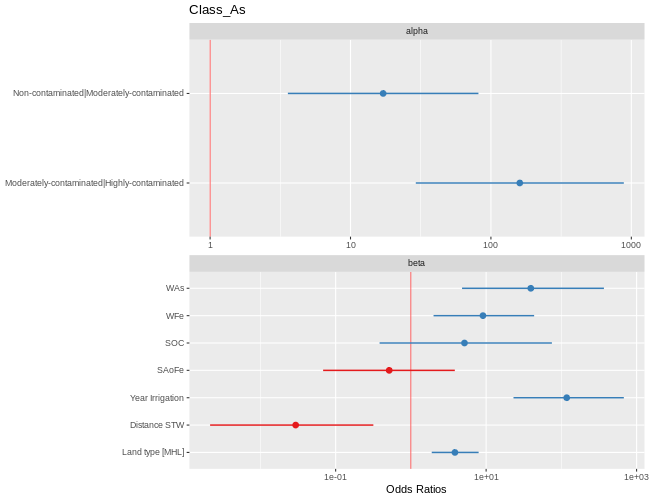

In [ ]:
%%R -w 650 -h 500 -u px
plot_model(fit.ordinal, vline.color = "red")

### Interpret the Odds Ratios

-   Exponentiate the coefficient: This converts the log odds ratio to an odds ratio. For example, if the coefficient for WAs is 8.195, the odds ratio associated with a one-unit increase in WAs is $e^{8.195}$

-   Interpret the odds ratio: When the odds ratio is greater than 1, it means that for each one-unit increase in the predictor variable, the odds of being in a higher category of the outcome increase by the value of the odds ratio. On the other hand, if the odds ratio is less than 1, it indicates that for each one-unit increase in the predictor variable, the odds of being in a higher category of the outcome decrease by the reciprocal of the odds ratio.

-   Check the significance: When interpreting the results, it's important to pay attention to the p-values associated with each coefficient. A p-value that is less than 0.05 suggests that the odds ratio is significantly different from 1, indicating a strong association between the predictor variable and the outcome category. It's crucial to remember that interpretation should always be done in the context of the specific research question and the nature of the data being analyzed.


### Model Performance

In [ ]:
%%R
performance::performance(fit.ordinal)

Can't calculate log-loss.


  cumulative link models.



# Indices of model performance

AIC     |    AICc |     BIC | Nagelkerke's R2 |  RMSE | Sigma
-------------------------------------------------------------
302.250 | 303.296 | 331.086 |           0.528 | 1.848 | 1.274


### Fitted Values

In [ ]:
%%R
fitted.values<-fit.ordinal$fitted.values
head(fitted.values, 20)

   Non-contaminated Moderately-contaminated Highly-contaminated
1         0.8631759              0.12024519         0.016578893
2         0.6867205              0.26700638         0.046273119
3         0.6604208              0.28772906         0.051850165
4         0.4405685              0.44045199         0.118979552
5         0.6660120              0.28335479         0.050633232
6         0.9401594              0.05311677         0.006723839
7         0.8908071              0.09632412         0.012868814
8         0.2634522              0.50735635         0.229191431
9         0.8173240              0.15945729         0.023218666
10        0.9608080              0.03487248         0.004319498
11        0.1295384              0.45366512         0.416796495
12        0.6671619              0.28245298         0.050385090
13        0.9135657              0.07647223         0.009962105
14        0.8958105              0.09197092         0.012218602
15        0.9531394              0.04165

### Test the Goodness of Fit

In [ ]:
%%R
chisq.test(train$Class_As,predict(fit.ordinal))


	Pearson's Chi-squared test

data:  train$Class_As and predict(fit.ordinal)
X-squared = 96.166, df = 4, p-value < 2.2e-16



### Confusion Matrix



In [ ]:
%%R
predict.train <-  predict(fit.ordinal,train)
c.train <- table(train$Class_As,predict.train)
c.train

                         predict.train
                          Non-contaminated Moderately-contaminated
  Non-contaminated                      49                      14
  Moderately-contaminated               15                      26
  Highly-contaminated                    2                      15
                         predict.train
                          Highly-contaminated
  Non-contaminated                          2
  Moderately-contaminated                  17
  Highly-contaminated                      42


### Misclassification Error

In [ ]:
%%R
mean(as.character(train$Class_As) != as.character(predict.train))

[1] 0.3571429


### Marginal Effects and Adjusted Predictions

The presentation of regression models, typically in the form of tables, is widely accepted as a clear and accessible method for interpreting results. However, for more intricate models that incorporate interaction or transformed terms, such as quadratic or spline terms, the use of raw regression coefficients may prove less effective, resulting in challenges when interpreting outcomes. In such cases, adjusted predictions or marginal means provide a more fitting solution. The use of visual aids can also assist in the comprehension of such effects or predictions, providing an intuitive understanding of the relationship between predictors and outcomes, even for complex models.


In [ ]:
%%R
margins::margins(fit.ordinal, variables = "WAs")

    WAs
 -1.089


{ggeffects} supports labelled data and the `plot()`- method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data.

  plots.



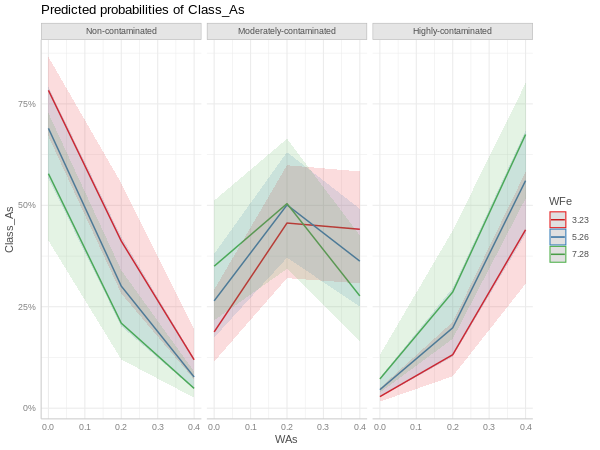

In [ ]:
%%R -w 600 -h 450 -u px
predict_response(fit.ordinal, terms = c("WAs", "WFe")) |>
plot(facets = TRUE)

### Cross-validation

In [ ]:
%%R
# Set the number of folds
K <- 5

# Create a vector to store misclassification rates for each fold
misclassification_rates <- numeric(K)

# Set seed for reproducibility
set.seed(123)

# Generate fold indices
folds <- sample(rep(1:K, length.out = nrow(df)))

# Loop through each fold
for (k in 1:K) {
  # Split the data into training and test sets
  train_data <- df[folds != k, ]
  test_data <- df[folds == k, ]

  # Fit the model on the training data
  model<-MASS::polr(Class_As~., data= df,
             Hess = TRUE)

  # Predict the class labels on the test set
    predicted_classes <- predict(model, newdata = test_data,  type = "class")

  # Calculate the misclassification rate for the current fold
  misclassified <- mean(predicted_classes == test_data$Class_As)
  fold_misclassification_rate <- misclassified / nrow(test_data)

  # Store the misclassification rate for this fold
  misclassification_rates[k] <- fold_misclassification_rate
}

# Calculate the average misclassification rate across all folds
avg_misclassification_rate <- mean(misclassification_rates)

# Display results
cat("Cross-Validated Misclassification Rates for Each Fold:", misclassification_rates, "\n")
cat("Average Cross-Validated Misclassification Rate:", avg_misclassification_rate, "\n")

Cross-Validated Misclassification Rates for Each Fold: 0.01281595 0.01174795 0.01317195 0.01368343 0.008505917 
Average Cross-Validated Misclassification Rate: 0.01198504 


### Prediction and Model Evaluation


#### Predicted Classes

In [ ]:
%%R
predictedClass <- predict(fit.ordinal, test)
head(predictedClass)

[1] Moderately-contaminated Non-contaminated        Non-contaminated       
[4] Non-contaminated        Non-contaminated        Non-contaminated       
Levels: Non-contaminated Moderately-contaminated Highly-contaminated


#### Predicted Probabilites

In [ ]:
%%R
predictedScores <- predict(fit.ordinal, test, type="p")
head(predictedScores)

  Non-contaminated Moderately-contaminated Highly-contaminated
1        0.3471316               0.4861844          0.16668400
2        0.8299989               0.1486820          0.02131907
3        0.8603704               0.1226623          0.01696730
4        0.8300323               0.1486535          0.02131412
5        0.8088840               0.1666036          0.02451237
6        0.8108544               0.1649373          0.02420824


#### Confusion Matrix

In [ ]:
%%R
table(test$Class_As, predictedClass)

                         predictedClass
                          Non-contaminated Moderately-contaminated
  Non-contaminated                      21                       5
  Moderately-contaminated                8                      10
  Highly-contaminated                    2                       4
                         predictedClass
                          Highly-contaminated
  Non-contaminated                          2
  Moderately-contaminated                   9
  Highly-contaminated                      20


#### Misclassifiaction Error

In [ ]:
%%R
mean(as.character(test$Class_As) != as.character(predictedClass))

[1] 0.3703704


## Summary and Conclusion

Understanding ordinal regression and how to implement it in R can provide valuable insights into the relationships between predictor variables and ordinal response variables. This can lead to a deeper understanding of the factors influencing the outcome of interest. It's important to approach ordinal regression carefully, taking into consideration the specific data and research question.

## References

1. [Ordinal logistic regression](https://www.bookdown.org/rwnahhas/RMPH/blr-ordinal.html)

2. [ORDINAL LOGISTIC REGRESSION | R DATA ANALYSIS EXAMPLES](https://stats.oarc.ucla.edu/r/dae/ordinal-logistic-regression/)

3. [How to Perform Ordinal Logistic Regression in R](https://www.r-bloggers.com/2019/06/how-to-perform-ordinal-logistic-regression-in-r/)

4. [Chapter 12 Ordinal Logistic Regression](https://bookdown.org/chua/ber642_advanced_regression/ordinal-logistic-regression.html)

5. [Handbook of Regression Modeling in People Analytics:](https://peopleanalytics-regression-book.org/)

Here are some books that cover Ordinal Regression and its implementation in R:

1. **"Modern Applied Statistics with S" by W.N. Venables and B.D. Ripley**
   - This book provides a comprehensive introduction to statistical modeling using S-PLUS and R, including chapters on ordinal regression models.

2. **"Ordinal Data Modeling" by Valen E. Johnson and James H. Albert**
   - This book focuses on ordinal data analysis and modeling, including techniques and applications in R.

3. **"Regression Modeling Strategies: With Applications to Linear Models, Logistic and Ordinal Regression, and Survival Analysis" by Frank E. Harrell Jr.**
   - This comprehensive book covers various regression modeling strategies, including ordinal regression, with practical examples and R code.

4. **"Analysis of Ordinal Categorical Data" by Alan Agresti**
   - This book provides an in-depth look at ordinal categorical data analysis, including ordinal regression models, with examples and code that can be adapted to R.

5. **"Generalized Linear Models with Examples in R" by Peter K. Dunn and Gordon K. Smyth**
   - This book offers a detailed introduction to generalized linear models, including ordinal regression models, with practical examples and R code.

6. **"Applied Ordinal Logistic Regression Using Stata: From Single-Level to Multilevel Modeling" by Xing Liu**
   - While this book primarily focuses on Stata, the concepts and methods discussed can be adapted for implementation in R.

7. **"Applied Regression Analysis and Generalized Linear Models" by John Fox**
   - This book provides a thorough introduction to regression analysis, including ordinal regression, with examples and R code.

These books provide a thorough understanding of ordinal regression models and their application in R, catering to both beginners and advanced users.